# Sigmoid Adiabatic State Preparation

Sigmoid Adiabatic State Preparation is a variation of adiabatic evolution where the transition between the initial and target Hamiltonians follows a **sigmoid curve**. This smooth, gradual transformation avoids abrupt changes and allows the system to closely follow the ground state path, as required by the **adiabatic theorem**.

In this example, the Hamiltonian $ H(t) $ is adjusted over time using a sigmoid function:

1. **Initial Hamiltonian, $ H_z $:** Encodes the initial ground state. Here, $ H_z = I \otimes Z + Z \otimes I $.
2. **Target Hamiltonian, $ H\_{xx} $:** Represents the desired end state. Here, $ H\_{xx} = X \otimes X $, which applies $X$-basis interactions.

The time-dependent Hamiltonian is given by:

$$
H(t) = -(1 - \text{sigmoid}) \cdot H_z - \text{sigmoid} \cdot H_{xx}
$$

where $\text{sigmoid} = \frac{1}{1 + e^{-0.5 \cdot (t - 10)}}$ is a sigmoid function that smoothly shifts the weight from $ H*z $ to $ H*{xx} $ as $ t $ progresses. Initially, $ H*z $ dominates; over time, the system increasingly aligns with $ H*{xx} $.

In this setup, a **two-qubit system** evolves under the `AnalogGate` defined by $ H(t) $ over 30 units of time. The gradual transition led by the sigmoid function allows the state to evolve gently towards the target ground state of $ H\_{xx} $, which is captured by `measure()` at the end, approximating the desired solution.


In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from oqd_analog_emulator.qutip_backend import QutipBackend
from oqd_core.backend.metric import Expectation
from oqd_core.backend.task import Task, TaskArgsAnalog
from oqd_core.interface.analog.operation import AnalogCircuit, AnalogGate
from oqd_core.interface.analog.operator import PauliI, PauliX, PauliY, PauliZ
from oqd_core.interface.math import MathStr

warnings.filterwarnings("ignore")

In [2]:
X, Y, Z, I = PauliX(), PauliY(), PauliZ(), PauliI()  # noqa: E741

In [3]:
Hxx = X @ X
Hz = I @ Z + Z @ I

sigmoid = MathStr(string=f"1/(1+{np.e}**(-(0.5*(t-10))))")

H = -(1 - sigmoid) * Hz + -sigmoid * Hxx

gate = AnalogGate(hamiltonian=H)

In [4]:
n = 2  # number of qubits
circuit = AnalogCircuit()
circuit.evolve(gate=gate, duration=30)
circuit.measure()

In [5]:
args = TaskArgsAnalog(
    n_shots=100,
    fock_cutoff=4,
    metrics={
        "Z": Expectation(operator=((I @ Z + Z @ I) * -0.5)),
        "XX": Expectation(operator=(X @ X) * -1),
    },
    dt=1e-2,
)

task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()
results = backend.run(task=task)

[1/1] Cythonizing qtcoeff_4c40d521ad5adc5cbe1184ce8eeeca.pyx
running build_ext
building 'qtcoeff_4c40d521ad5adc5cbe1184ce8eeeca' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Id:\work\Projects\equilux\.venv\Lib\site-packages\qutip\core\data -Id:\work\Projects\equilux\.venv\Lib\site-packages\numpy\core\include -Id:\work\Projects\equilux\.venv\include -IC:\Users\Salieri\AppData\Roaming\uv\python\cpython-3.12.9-windows-x86_64-none\include -IC:\Users\Salieri\AppData\Roaming\uv\python\cpython-3.12.9-windows-x86_64-none\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.42.34433\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Fi

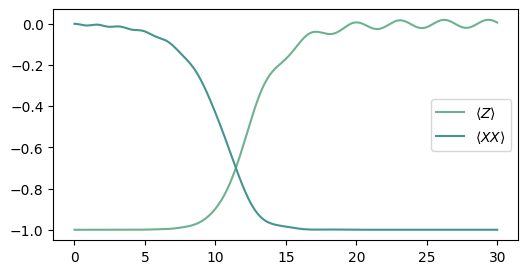

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=4)

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend();

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


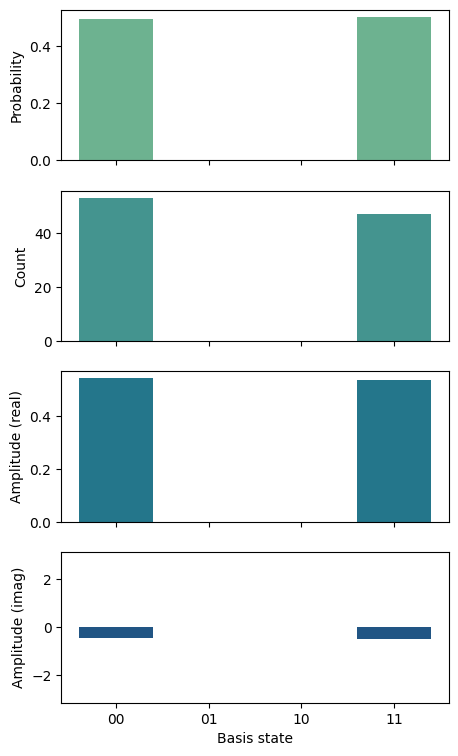

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")

ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")

ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi]);